In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls

drive  sample_data


In [4]:
cd drive/My Drive/데이콘

/content/drive/My Drive/데이콘


In [6]:
!git init

Initialized empty Git repository in /content/drive/My Drive/데이콘/.git/


In [7]:
!git config --global user.email "csm5588@gmail.com"
!git config --global user.name "Hermi2020"

In [8]:
!git add .

In [10]:
!git commit -m "Init Project"

On branch master

Initial commit

nothing to commit


In [9]:
!git remote add origin https://github.com/Hermi2020/PrecipitationPrediction.git

In [ ]:
import zipfile

path = '/content/drive/My Drive/강우예측AI'

#압축 해제된 파일은 content 즉, colab 상에 위치하므로 세션이 초기화 되면 삭제됨
#압축 해제 위치를 구글 드라이브 강우예측AI 폴더로 지정 가능

zip_file = zipfile.ZipFile(path+'/train.zip')
zip_file.extractall('.')

zip_file = zipfile.ZipFile(path+'/test.zip')
zip_file.extractall('./test/')

In [ ]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, concatenate, Input
from tensorflow.keras import Model

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_files = glob.glob('/content/train/*.npy')
len(train_files)

62735

In [ ]:
def trainGenerator():
    for file in train_files:
        dataset = np.load(file)
        target= dataset[:,:,-1].reshape(120,120,1)
        remove_minus = np.where(target < 0, 0, target)
        feature = dataset[:,:,:4]

        yield (feature, remove_minus)
        
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([120,120,4]),tf.TensorShape([120,120,1])))
train_dataset = train_dataset.batch(256).prefetch(1)

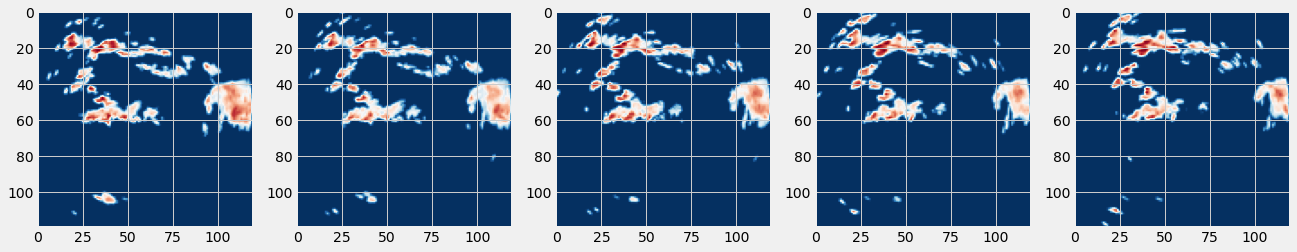

In [ ]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()
image_sample = np.load(train_files[42])

plt.style.use('fivethirtyeight')
plt.figure(figsize=(20, 20))

for i in range(4):
    plt.subplot(1,5,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(1,5,5)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

In [ ]:
def base_model(input_layer, start_neurons):
    
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)

    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((120, 120, 4))
output_layer = base_model(input_layer,64)

model = Model(input_layer, output_layer)
model.compile(loss='mae', optimizer='adam')
model.fit(train_dataset, epochs = 5, verbose=1)

Epoch 1/5
      2/Unknown - 1s 670ms/step - loss: 11.9351WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.4189s vs `on_train_batch_end` time: 0.9050s). Check your callbacks.
246/246 [==============================] - 353s 1s/step - loss: 7.2294
Epoch 2/5
246/246 [==============================] - 358s 1s/step - loss: 3.2336
Epoch 3/5
246/246 [==============================] - 357s 1s/step - loss: 3.0975
Epoch 4/5
246/246 [==============================] - 357s 1s/step - loss: 3.0495
Epoch 5/5
246/246 [==============================] - 357s 1s/step - loss: 3.0240


In [ ]:
test_path = '/content/test'
test_files = sorted(glob.glob(test_path + '/*.npy'))

X_test = []

for file in tqdm(test_files, desc = 'test'):
    data = np.load(file)
    X_test.append(data)

X_test = np.array(X_test)

test: 100%|██████████| 2674/2674 [00:04<00:00, 593.00it/s]


In [ ]:
pred = model.predict(X_test)

In [ ]:
submission = pd.read_csv('/content/drive/My Drive/강우예측AI/sample_submission.csv')

submission.iloc[:,1:] = pred.reshape(-1, 14400).astype(int)
submission.to_csv(path + '/Dacon_baseline.csv', index = False)